In [1]:
import os
import shutil
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from rinet.data_sim import random_mixture_sample

# # for reproducibility
# SEED = 13
# np.random.seed(SEED)


In [2]:
# generate dataset

data_path = '../simulated_quality_check/'

n_dimensions = 1  # number of dimensions
n_components = [1, 2]  # possible number of pathological components
sample_sizes = [250, 500]  # possible no. samples
mean_range = [-3, 3]  # min/max possible mean of distributions
pathological_dev_percentage_range = [30, 60]

n_samples = 10000

data = []  # list of vectors containing mixture samples
sizes = []
components = []
mean_vecs = []
std_devs = []
for i in range(n_samples):

    if i % 500 == 0:
        print(i)

    sample, mean_vectors, stds, comps, sz = random_mixture_sample(
        n_dimensions=n_dimensions, 
        n_components=np.random.choice(n_components),
        n_samples=np.random.uniform(sample_sizes[0], sample_sizes[1]),
        quantize_step=np.random.choice([0, 0.05]),
        mean_range=mean_range,
        pathological_dev_percentage_range=pathological_dev_percentage_range,
        p_frac_range=[0.20, 0.30],  # min/max pathological fraction
    )

    data.append(sample)
    mean_vecs.append(mean_vectors)
    std_devs.append(stds)
    components.append(comps)
    sizes.append(sz)



0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [3]:
# standardize samples, so model can be scale independent
data_scaled = []
targets = []
for c, i in enumerate(data):

    if c % 500 == 0:
        print(c)

    # record scaled data points
    data_scaled.append((i-i.mean(axis=0))/i.std(axis=0))

    # transform target statistics
    a = 1 / i.std(axis=0)  # reciprocal of sample std for scaling
    b = -i.mean(axis=0)  # negative of sample mean for shifting
    transformed_mean = a * (mean_vecs[c][0] + b)  # transform mean
    transformed_std = a * std_devs[c][0]

    # create NN target from standardized sample
    targets.append(np.hstack([
        transformed_mean,
        transformed_std,
        sizes[c][0]/sum(sizes[c])
    ]))


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [4]:
# split
idx_train = np.arange(n_samples)
idx_test = np.array([])
idx_val = np.array([])


In [5]:
# save generated data
if not os.path.exists(data_path):
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')
else:
    shutil.rmtree(data_path)
    os.makedirs(data_path)
    os.makedirs(data_path+'/train/')
    os.makedirs(data_path+'/val/')
    os.makedirs(data_path+'/test/')

for idx, split in zip([idx_train, idx_val, idx_test], ['train', 'val', 'test']):
    with open(data_path+'/' + split + '/input_data.pkl', 'wb') as handle:
        pickle.dump([data_scaled[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/original_data.pkl', 'wb') as handle:
        pickle.dump([data[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/target_data.pkl', 'wb') as handle:
        pickle.dump([targets[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/means.pkl', 'wb') as handle:
        pickle.dump([mean_vecs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/stds.pkl', 'wb') as handle:
        pickle.dump([std_devs[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/sizes.pkl', 'wb') as handle:
        pickle.dump([sizes[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(data_path+'/' + split + '/components.pkl', 'wb') as handle:
        pickle.dump([components[i] for i in idx], 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)


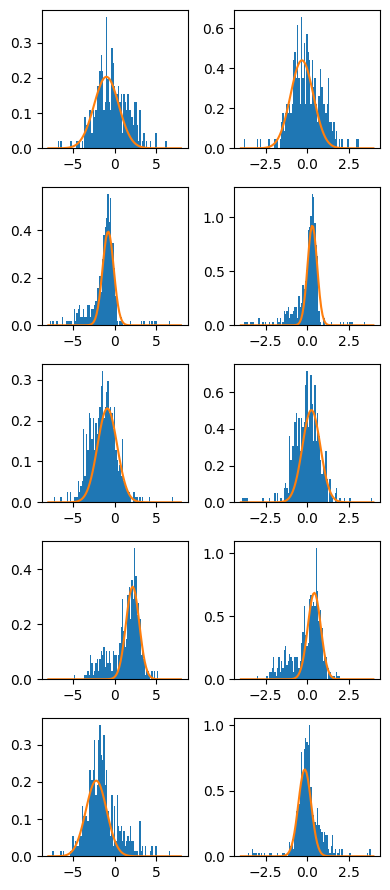

In [6]:
# checking transformation:

# does a sample using standardized target parameters match the reference Gaussian?

import matplotlib.pyplot as plt
from rinet.data_sim import plot_1d_mixture
from scipy.stats import norm

plt.figure(figsize=(4, 9))
x_range = np.linspace(-8, 8, 100)
x_range_standard = np.linspace(-4, 4, 100)
for i in range(5):

    idx = np.random.choice(len(data))  # select random sample index

    # plot unscaled data
    plt.subplot(5, 2, (i*2)+1)
    plt.hist(data[idx], x_range, density=True)
    pdf = norm(loc=mean_vecs[idx][0], scale=std_devs[idx][0]).pdf(x_range)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range, pdf)

    # plot scaled sample
    plt.subplot(5, 2, (i*2)+2)
    plt.hist(data_scaled[idx], x_range_standard, density=True)
    pdf = norm(loc=targets[idx][0], scale=targets[idx][1]).pdf(x_range_standard)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range_standard, pdf)

plt.gcf().tight_layout()


(array([  6.,   8.,  19.,  53.,  60., 110., 148., 182., 210., 245., 280.,
        320., 313., 349., 381., 441., 496., 459., 472., 458., 462., 478.,
        465., 426., 391., 404., 364., 285., 278., 225., 225., 174., 139.,
        153., 121.,  90.,  81.,  56.,  48.,  36.,  32.,  26.,   9.,   9.,
          6.,   1.,   2.,   2.,   0.,   2.]),
 array([0.14908422, 0.16927574, 0.18946726, 0.20965877, 0.22985029,
        0.25004181, 0.27023333, 0.29042484, 0.31061636, 0.33080788,
        0.3509994 , 0.37119092, 0.39138243, 0.41157395, 0.43176547,
        0.45195699, 0.47214851, 0.49234002, 0.51253154, 0.53272306,
        0.55291458, 0.5731061 , 0.59329761, 0.61348913, 0.63368065,
        0.65387217, 0.67406369, 0.6942552 , 0.71444672, 0.73463824,
        0.75482976, 0.77502128, 0.79521279, 0.81540431, 0.83559583,
        0.85578735, 0.87597887, 0.89617038, 0.9163619 , 0.93655342,
        0.95674494, 0.97693645, 0.99712797, 1.01731949, 1.03751101,
        1.05770253, 1.07789404, 1.09808556, 1.

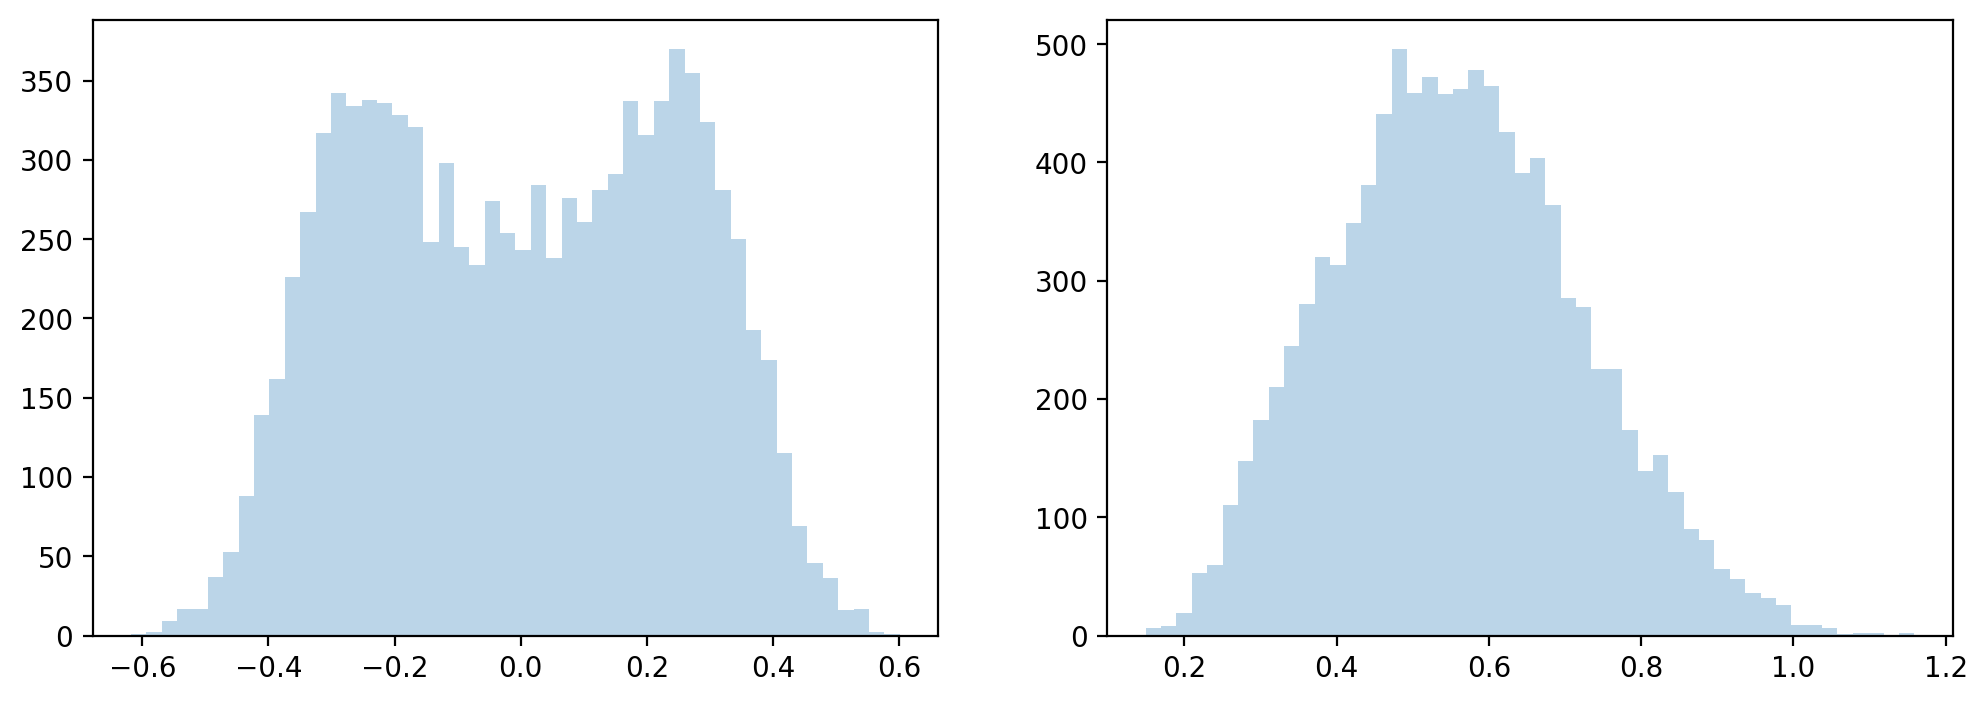

In [7]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in targets], 50, alpha=0.3)
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in targets], 50, alpha=0.3)
